# Explore here

In [1]:
# lectura de los datos
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633

In [3]:
#cambiar el formato de date a date_time
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


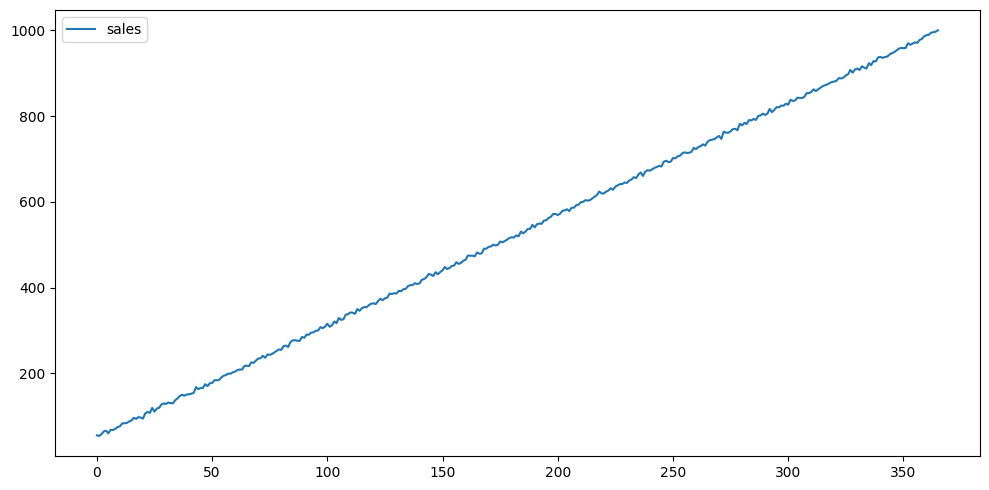

In [6]:
#graficar la serie de tiempo
import matplotlib.pyplot as plt
import seaborn as sns

#para visualizar mejor, le damos un figsize
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
plt.tight_layout()
plt.show()

In [9]:
#df['date'] = df['date'].dt.date
df = df.set_index('date')
#revisar set index

In [10]:
#descomponer la serie. 
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, period=30)

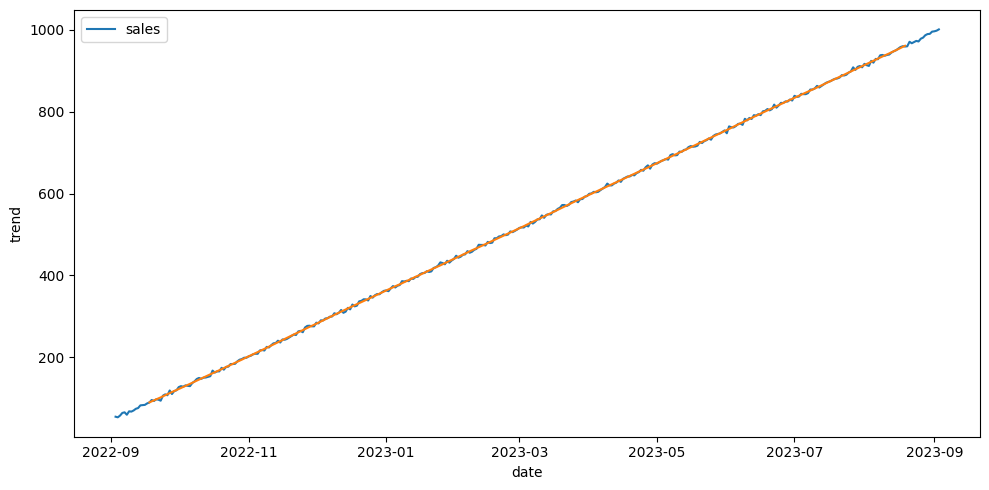

In [16]:
tendencia = decomposition.trend
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=tendencia)
plt.tight_layout()
plt.show()

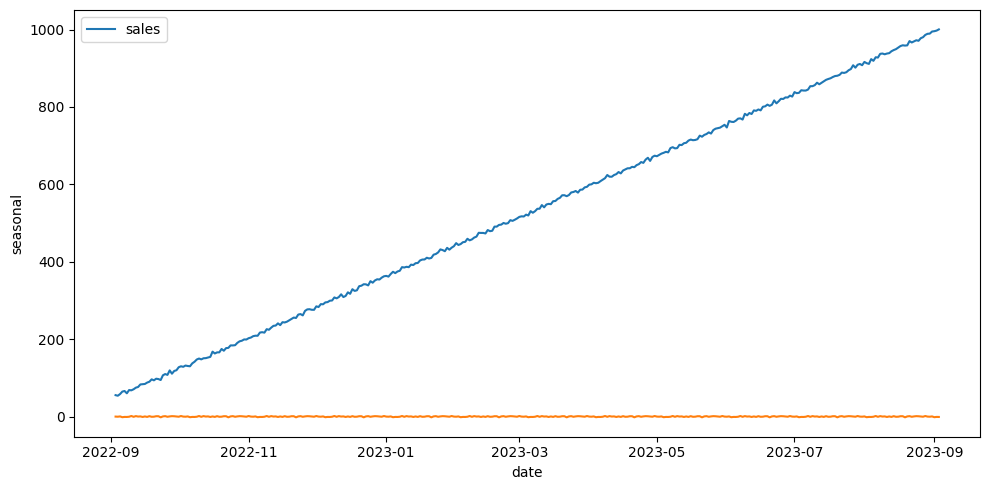

In [15]:
estacional = decomposition.seasonal
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=estacional)
plt.tight_layout()
plt.show()

In [18]:
#completar
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

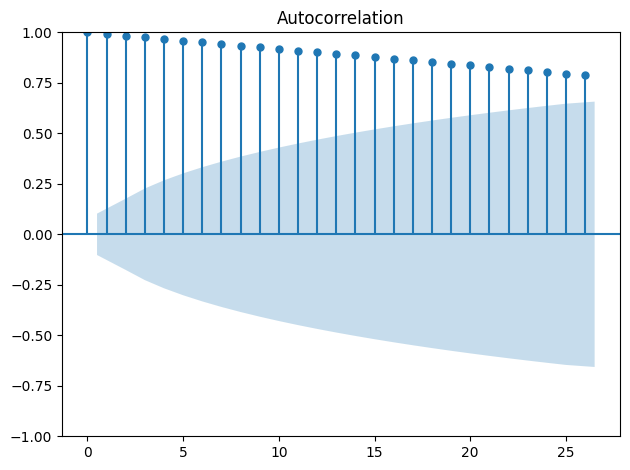

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df)
plt.tight_layout()
plt.show()

In [19]:
#transformamos la serie a estacionaria
df_stationary = df.diff().dropna()
test_stationarity(df_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [20]:
#ahora la serie es estacionaria y podemos aplicar el metodo ARIMA
#el seasonal es tan peque√±o que lo ponemos como false
from pmdarima import auto_arima

model = auto_arima(df_stationary, seasonal=False, trace = True, m=30)

/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (30) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1854.829, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2205.881, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2208.143, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1857.381, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1843.049, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1843.587, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1841.533, Time=0.27 sec
 A

In [21]:
#resumen del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Sat, 11 May 2024   AIC                           1839.553
Time:                        00:38:54   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
#ahora hacemos un split sobre la variable tiempo, del 9 de enero de 2023 hacia atras y hacia adelante
train_df = df_stationary[df_stationary.index < pd.to_datetime('2023-07-25').date()]
test_df = df_stationary[df_stationary.index >= pd.to_datetime('2023-07-07').date()]

In [24]:
model = auto_arima(train_df, seasonal=False, trace = True, m=30)

/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (30) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1113.472, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1113.279, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1114.124, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1100.065, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1070.234, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1062.178, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1048.828, Time=0.09 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=963.733, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=968.800, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=941.833, Time=0.34 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=940.340, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=944.112, T

In [25]:
forcast = model.predict(63)

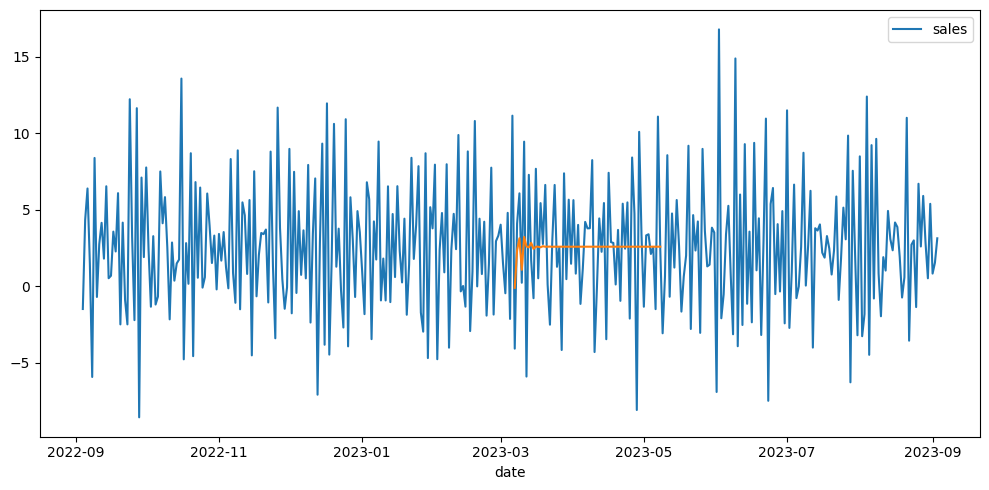

In [27]:
plt.subplots(figsize=(10,5))
sns.lineplot(data=df_stationary)
sns.lineplot(data=forcast)
plt.tight_layout()
plt.show()